In [145]:
%matplotlib inline
%matplotlib notebook
import bagpy
from bagpy import bagreader
import rosbag
from ros_numpy.point_cloud2 import pointcloud2_to_array
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import cv2

In [20]:
b = bagreader('../Data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag')

[INFO]  Data folder ../Data/A_Spot_Library_Dobie_Wed_Nov_10_57 already exists. Not creating.


In [21]:
b.topic_table

,Topics,Types,Message Count,Frequency
0,/image_raw/compressed,sensor_msgs/CompressedImage,6687,29.939640
1,/joint_states,sensor_msgs/JointState,3696,16.440965
2,/joystick,sensor_msgs/Joy,13413,59.996195
3,/localization,amrl_msgs/Localization2DMsg,3698,16.562631
4,/navigation/cmd_vel,geometry_msgs/Twist,8990,40.001755
5,/odom,nav_msgs/Odometry,3696,16.546622
6,/scan,sensor_msgs/LaserScan,2228,9.915097
7,/spot/camera/back/camera_info,sensor_msgs/CameraInfo,1006,4.476450
8,/spot/camera/back/image/compressed,sensor_msgs/CompressedImage,1006,4.476875
9,/spot/camera/frontleft/camera_info,sensor_msgs/CameraInfo,1006,4.473008


In [33]:
print(b.start_time)
print(b.end_time)
(b.end_time - b.start_time)/60

1636567736.4969425
1636567961.2256763


3.745478896299998

In [22]:
path = b.message_by_topic(topic='/localization')

In [38]:
scan_df = pd.read_csv(path)
scan_df.tail()

,Time,header.seq,header.stamp.secs,header.stamp.nsecs,header.frame_id,pose.x,pose.y,pose.theta,map
3693,1.636568e+09,13263,1636567960,998346329,map,473.157471,-200.449295,-2.733637,UT_Campus
3694,1.636568e+09,13264,1636567961,78962564,map,473.109497,-200.418137,-2.784835,UT_Campus
3695,1.636568e+09,13265,1636567961,119125605,map,473.112152,-200.410202,-2.820620,UT_Campus
3696,1.636568e+09,13266,1636567961,182421684,map,473.118347,-200.402054,-2.855987,UT_Campus
3697,1.636568e+09,13267,1636567961,222807407,map,473.201111,-200.340256,-2.873678,UT_Campus


In [9]:
scan_df[['pose.x', 'pose.y', 'pose.theta']].describe()

,pose.x,pose.y,pose.theta
count,3698.000000,3698.000000,3698.000000
mean,492.131775,-53.853419,-1.655655
std,10.100189,85.501715,0.166158
min,473.047302,-200.682571,-2.873678
25%,483.671234,-126.561987,-1.687758
50%,493.529968,-53.409826,-1.631537
75%,499.157295,21.061259,-1.580580
max,511.892639,90.257904,-1.116677


In [22]:
bag = rosbag.Bag('../Data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag')

In [23]:
def point_cloud_2_birdseye(points, res=0.125, side_range=(-16., 16.), fwd_range=(0, 32.)):
    x_points = points['x']
    y_points = points['y']
    z_points = points['z']
    intensity = points['intensity']
    
    # FILTER - To return only indices of points within desired cube
    # Three filters for: Front-to-back, side-to-side, and height ranges
    # Note left side is positive y axis in LIDAR coordinates
    f_filt = np.logical_and((x_points > fwd_range[0]), (x_points < fwd_range[1]))
    s_filt = np.logical_and((y_points > -side_range[1]), (y_points < -side_range[0]))
    filter = np.logical_and(f_filt, s_filt)
    indices = np.argwhere(filter).flatten()

    # KEEPERS
    x_points = x_points[indices]
    y_points = y_points[indices]
    z_points = z_points[indices]
    intensity = intensity[indices]

    # CONVERT TO PIXEL POSITION VALUES - Based on resolution
    x_img = (-y_points / res).astype(np.int32)  # x axis is -y in LIDAR
    y_img = (-x_points / res).astype(np.int32)  # y axis is -x in LIDAR

    # SHIFT PIXELS TO HAVE MINIMUM BE (0,0)
    # floor & ceil used to prevent anything being rounded to below 0 after shift
    x_img -= int(np.floor(side_range[0] / res))
    y_img += int(np.ceil(fwd_range[1] / res))
    
    """
    # CLIP HEIGHT VALUES - to between min and max heights
    pixel_values = np.clip(a=z_points,
                           a_min=height_range[0],
                           a_max=height_range[1])

    # RESCALE THE HEIGHT VALUES - to be between the range 0-255
    pixel_values = scale_to_255(pixel_values,
                                min=height_range[0],
                                max=height_range[1])
    """
    #intensity_ind = (intensity > 20)
    #intensity[intensity_ind] = 255
    pixel_values = intensity

    # INITIALIZE EMPTY ARRAY - of the dimensions we want
    x_max = 1 + int((side_range[1] - side_range[0]) / res)
    y_max = 1 + int((fwd_range[1] - fwd_range[0]) / res)
    im = np.zeros([y_max, x_max], dtype=np.uint8)

    # FILL PIXEL VALUES IN IMAGE ARRAY
    im[y_img, x_img] = pixel_values

    return im

In [24]:
bev_frms = []
for topic, msg, t in tqdm(bag.read_messages(topics='/velodyne_points')):
    a = pointcloud2_to_array(msg)
    bev = point_cloud_2_birdseye(a, res=0.046875, side_range=(-6.,6.), fwd_range=(0,12.))
    bev_frms.append(bev)

2228it [00:01, 1546.93it/s]


<IPython.core.display.Javascript object>


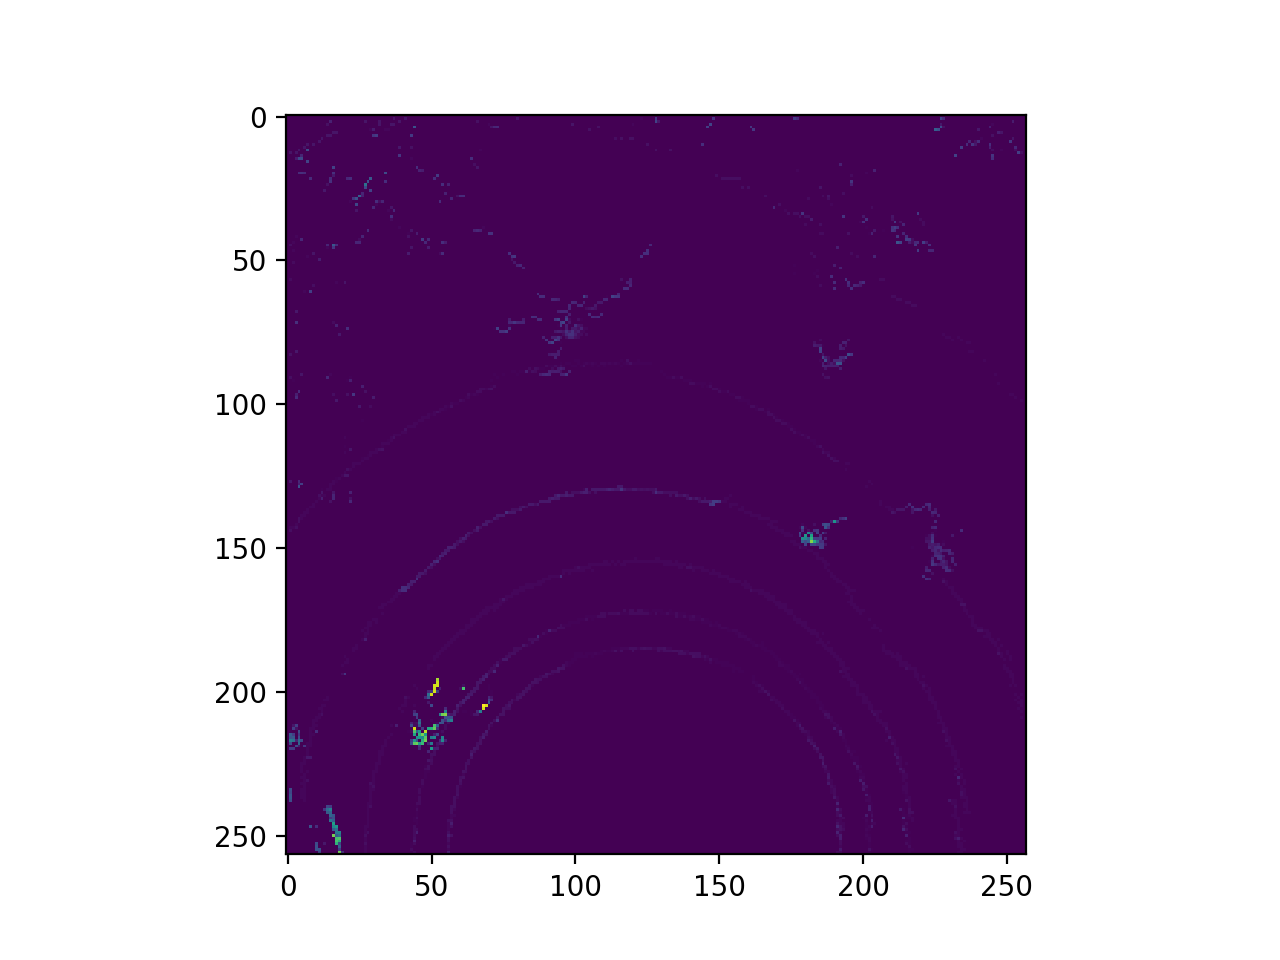

In [25]:
fig, ax = plt.subplots()
ims = []

for i in range(len(bev_frms)):
    im = ax.imshow(bev_frms[i], animated=True)
    if i == 0:
        ax.imshow(bev_frms[i])  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
plt.show()
#print(bev_frms[0].shape)
#plt.imshow(bev_frms[1])

<IPython.core.display.Javascript object>


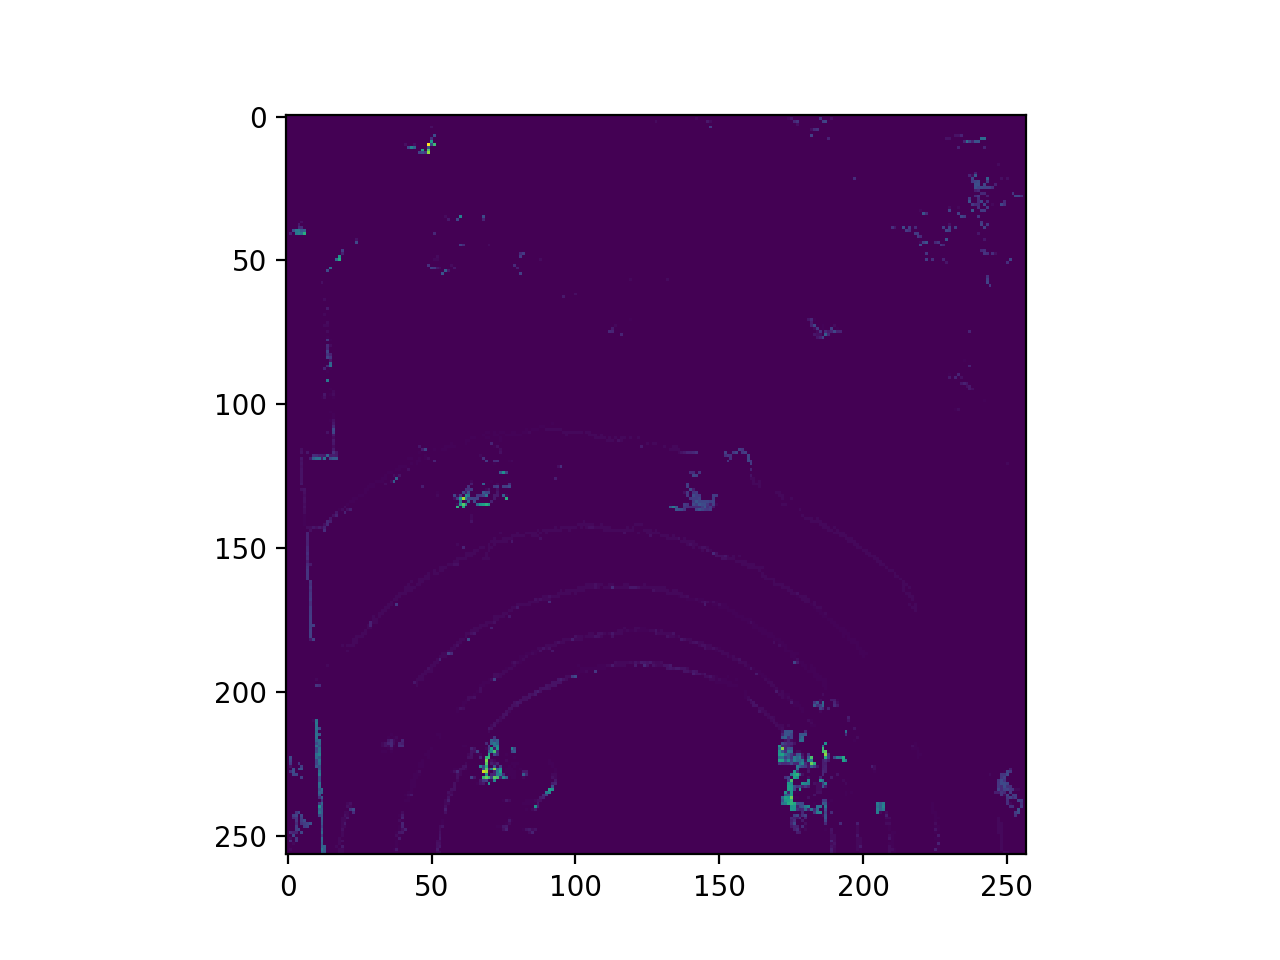

In [26]:
#print(bev_frms[0].shape)
plt.figure(2)
plt.imshow(bev_frms[0])

In [64]:
bev_frms[1][215:245, 67:80]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  23,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  10,  18,  27,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  12,  36,  33,   0,   0,   0,   0,   0,   0],
       [  0,   5,   0,   0,  39,  43,  40,   0,   0,   0,   0,   0,   0],
       [  0,   0,  17,   0,   1,  51,  53,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,  56,   8,   8,   0,   0,   0,   1,  50,  33],
       [  0,   0,  27,  55,   0,  67,   8,   0,   0,   0,   0,  27,   0],
       [ 31,   0,  61,  66,   0,   0,  11,   0,   0,   0,   0,   0,   0],
       [  0,   0,  77,   0,   4,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,  75,   0,   6,   7,   0,   0,   0,   0,   0,   0,   1],
       [  0,   0,  30,   0,   0,   9,   4,  14,   0,   0,   1,   0,   1],
       [  0,  24,  77,  12,  15,  16,   0,  28,   0,   1,   1,   1,   0],
       [  0,  45, 100,   0,  55,  16, 

In [133]:
rbg_img = []
msg_cnt = 0
for topic, msg, t in tqdm(bag.read_messages(topics='/image_raw/compressed')):
    a = np.frombuffer(msg.data, np.uint8)
    mat = cv2.imdecode(a, cv2.IMREAD_COLOR)
    img = np.asarray(mat)
    rbg_img.append(img)
    msg_cnt += 1
    if(msg_cnt == 400):
        break

399it [00:02, 186.89it/s]


(720, 1280, 3)


<IPython.core.display.Javascript object>


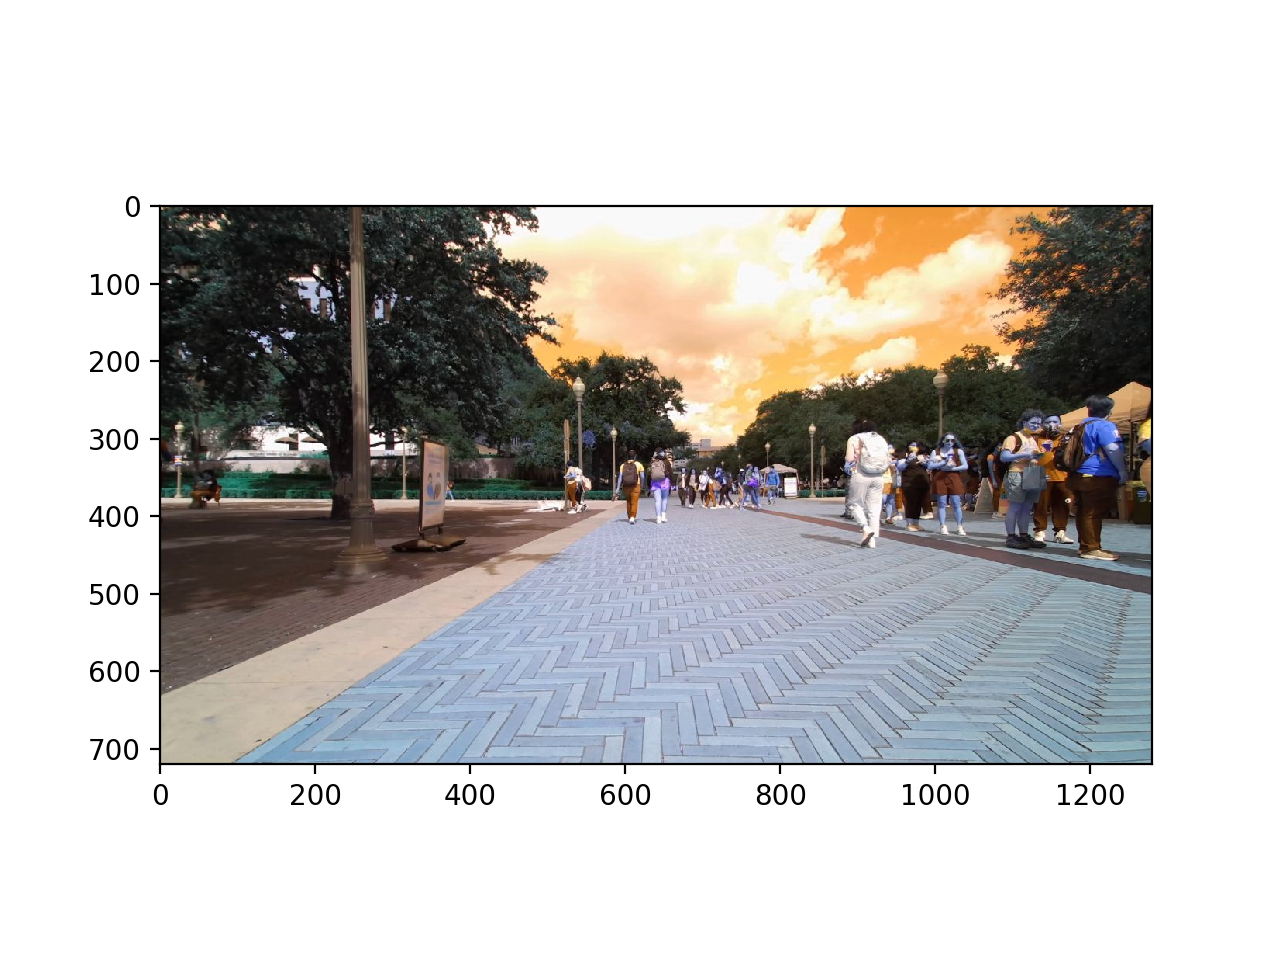

In [146]:
print(rbg_img[0].shape)
plt.figure(3)
plt.imshow(rbg_img[0])

In [43]:
print(np.min(a['intensity']), np.max(a['intensity']))

0.0 255.0


<IPython.core.display.Javascript object>


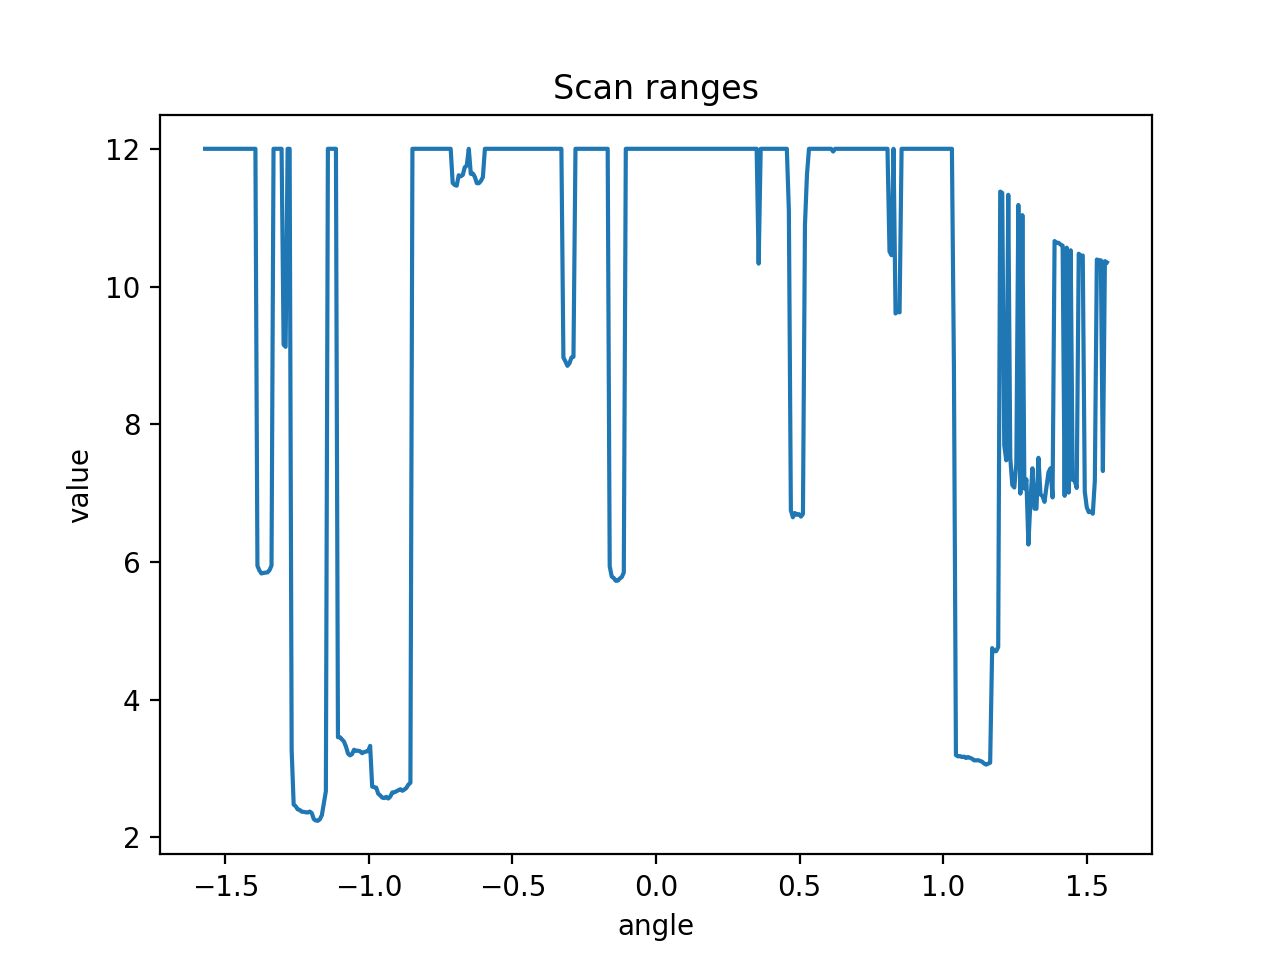

Text(0.5, 1.0, 'Scan ranges')

In [7]:
#fig, ax = plt.subplots()
plt.figure(4)
angle = np.linspace(-np.pi/2, np.pi/2, len(scan))
plt.plot(angle, scan)
plt.xlabel('angle')
plt.ylabel('value')
plt.title('Scan ranges')
#plt.show()

<IPython.core.display.Javascript object>


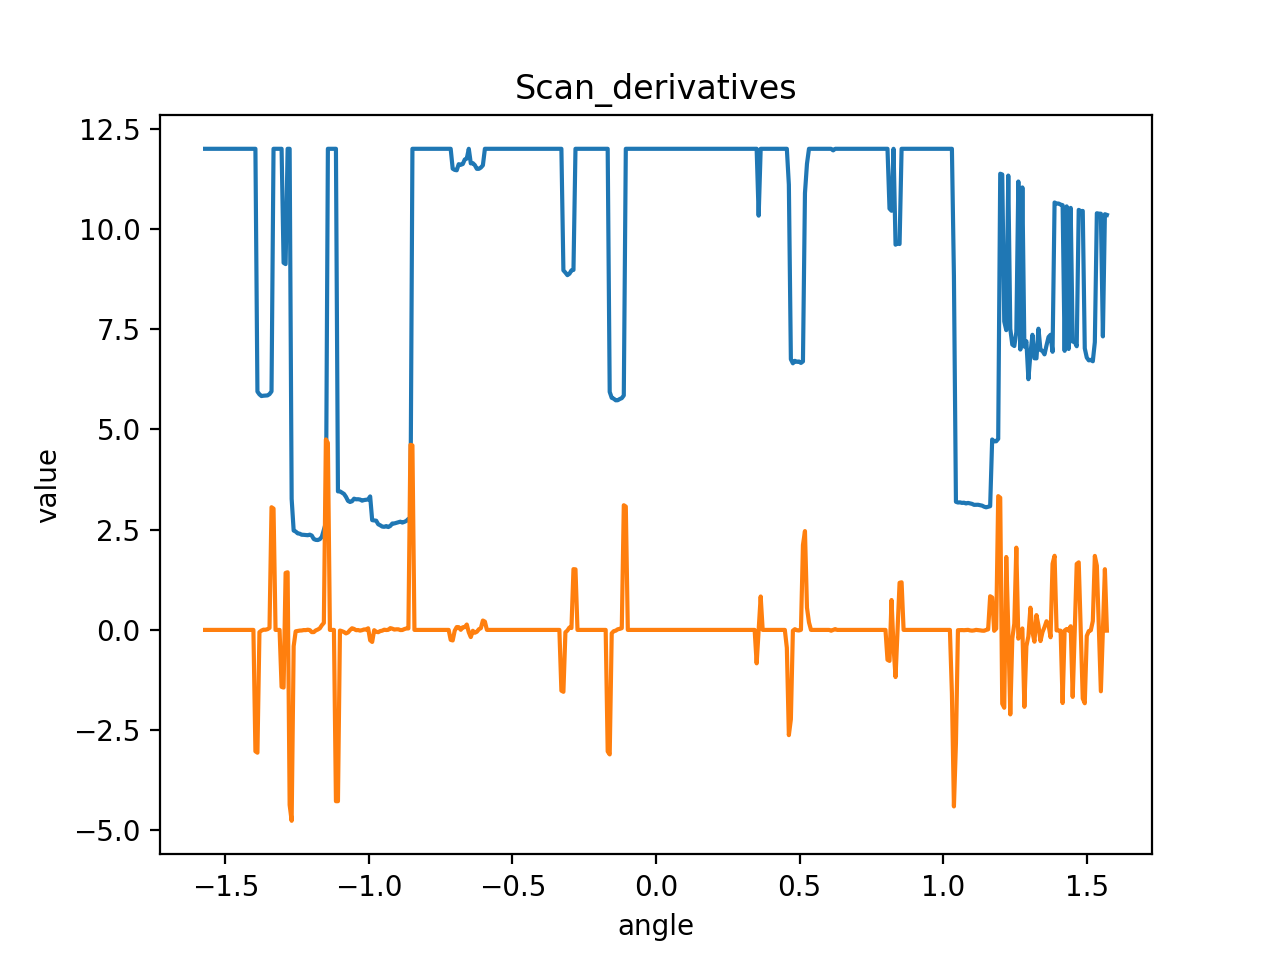

Text(0.5, 1.0, 'Scan_derivatives')

In [10]:
np_der = np.gradient(scan)
plt.figure(5)
plt.plot(angle, scan, label='ranges')
plt.plot(angle, np_der, label='np_gra')
plt.xlabel('angle')
plt.ylabel('value')
plt.title('Scan_derivatives')

In [146]:
def locate_cylinder(scan, grad, thres=2.4, ang_incr=0.007000000216066837):
    loc_list = []
    on_cylinder = False
    sum_ray, sum_range, rays = 0.0, 0.0, 0
    num = 0
    
    for i in range(len(grad)):
        if grad[i] <= -thres:
            on_cylinder = True
            sum_ray, sum_range, rays = 0.0, 0.0, 0
        elif grad[i] >= thres:
            if on_cylinder:
                num += 1
                loc_list.append((sum_range/rays, -np.pi/2 + (sum_ray/rays)*ang_incr))
            on_cylinder = False
        
        if on_cylinder:
            sum_ray += i
            sum_range += scan[i]
            rays += 1
    #print(num)
    return loc_list
    

In [147]:
def get_xy(cyl_list):
    x, y = [], []
    for r, theta in cyl_list:
        x.append(r*np.cos(theta))
        y.append(r*np.sin(theta))
        #cart_list.append((r*np.cos(theta), r*np.sin(theta)))
    return x, y
#x, y = get_xy(cyl_list)

In [148]:
def get_affine_mat(x, y, theta):
    return np.array([[np.cos(theta), -np.sin(theta), x],
                         [np.sin(theta), np.cos(theta), y],
                         [0, 0, 1]])    

In [149]:
def get_global_xy(loc_x, loc_y, rob_pose):
    affine_mat = get_affine_mat(rob_pose.x, rob_pose.y, rob_pose.theta)
    loc_x = np.asarray(loc_x)
    loc_y = np.asarray(loc_y)
    loc_pos = np.array([loc_x,loc_y,np.ones(loc_x.shape)])
    glob_pos = np.matmul(affine_mat, loc_pos)
    return glob_pos[0], glob_pos[1]

In [150]:
b1 = bagreader('../Data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag_synchronized.bag')

[INFO]  Data folder ../Data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag_synchronized already exists. Not creating.


In [151]:
b1.topic_table

,Topics,Types,Message Count,Frequency
0,/localization,amrl_msgs/Localization2DMsg,2228,8.295598
1,/scan,sensor_msgs/LaserScan,2228,9.914558


In [152]:
bag1 = rosbag.Bag('../Data/A_Spot_Library_Dobie_Wed_Nov_10_57.bag_synchronized.bag')

In [153]:
def get_traj(bagfile, start_frm=0, num_frm=100):
    lox, loy = [], []
    tmx, tmy = [], []
    msgcnt = 0
    for topic, msg, t in bag.read_messages(topics='/scan'):
        #print(np.asarray(msg.ranges)
        #print(msg)
        if msgcnt >= start_frm:
            scan = np.asarray(msg.ranges)
            start = int(np.pi/(2*msg.angle_increment))
            end = int(np.pi*3/(2*msg.angle_increment))
            scan = scan[start:end]
            scan[scan>12] = 12
            np_der = np.gradient(scan)
            cyl_list = locate_cylinder(scan, np_der)
            x, y = get_xy(cyl_list)
            lox.append(x)
            loy.append(y)
            tmx += x
            tmy += y
        msgcnt += 1
        if msgcnt == start_frm + num_frm:
            break
    
    #print(lox, loy)
    plt.figure(7)
    plt.scatter(tmy, tmx)
    msgcnt = 0
    glx, gly = [], []
    robx, roby = [], []
    for i, (topic, msg, t) in enumerate(bag.read_messages(topics='/localization')):
        if msgcnt >= start_frm:
            rob_pose = msg.pose
            robx.append(msg.pose.x)
            roby.append(msg.pose.y)
            glob_x, glob_y = get_global_xy(lox[i-msgcnt], loy[i-msgcnt], rob_pose)
            #print(glob_x, glob_y)
            glx += list(glob_x)
            gly += list(glob_y)
        #print(glob_x, glob_y)
        msgcnt += 1
        if msgcnt == start_frm + num_frm:
            break
    #plt.scatter(glx, gly)
    return glx, gly, robx, roby
    

<IPython.core.display.Javascript object>


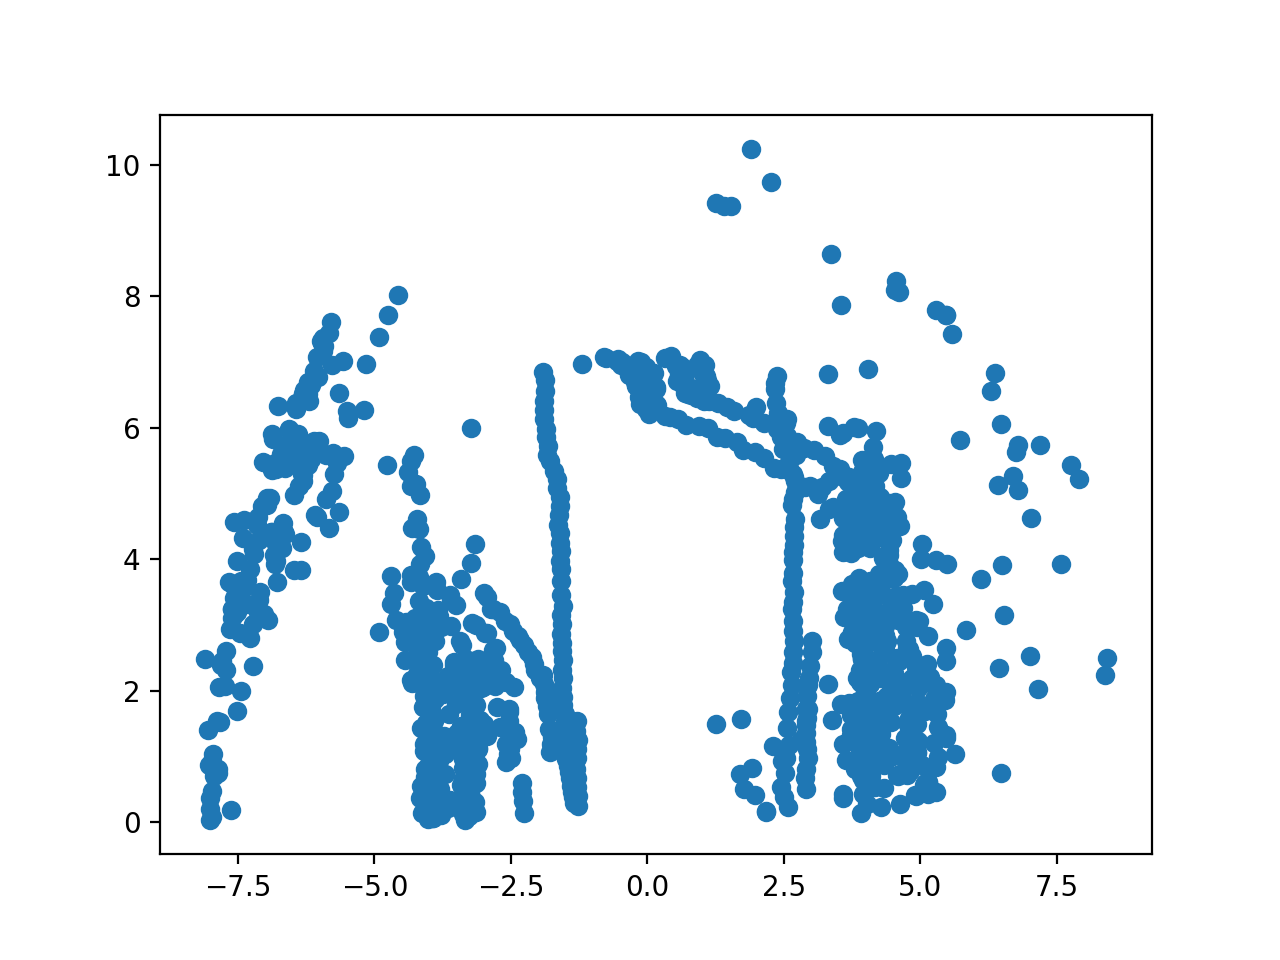

<IPython.core.display.Javascript object>


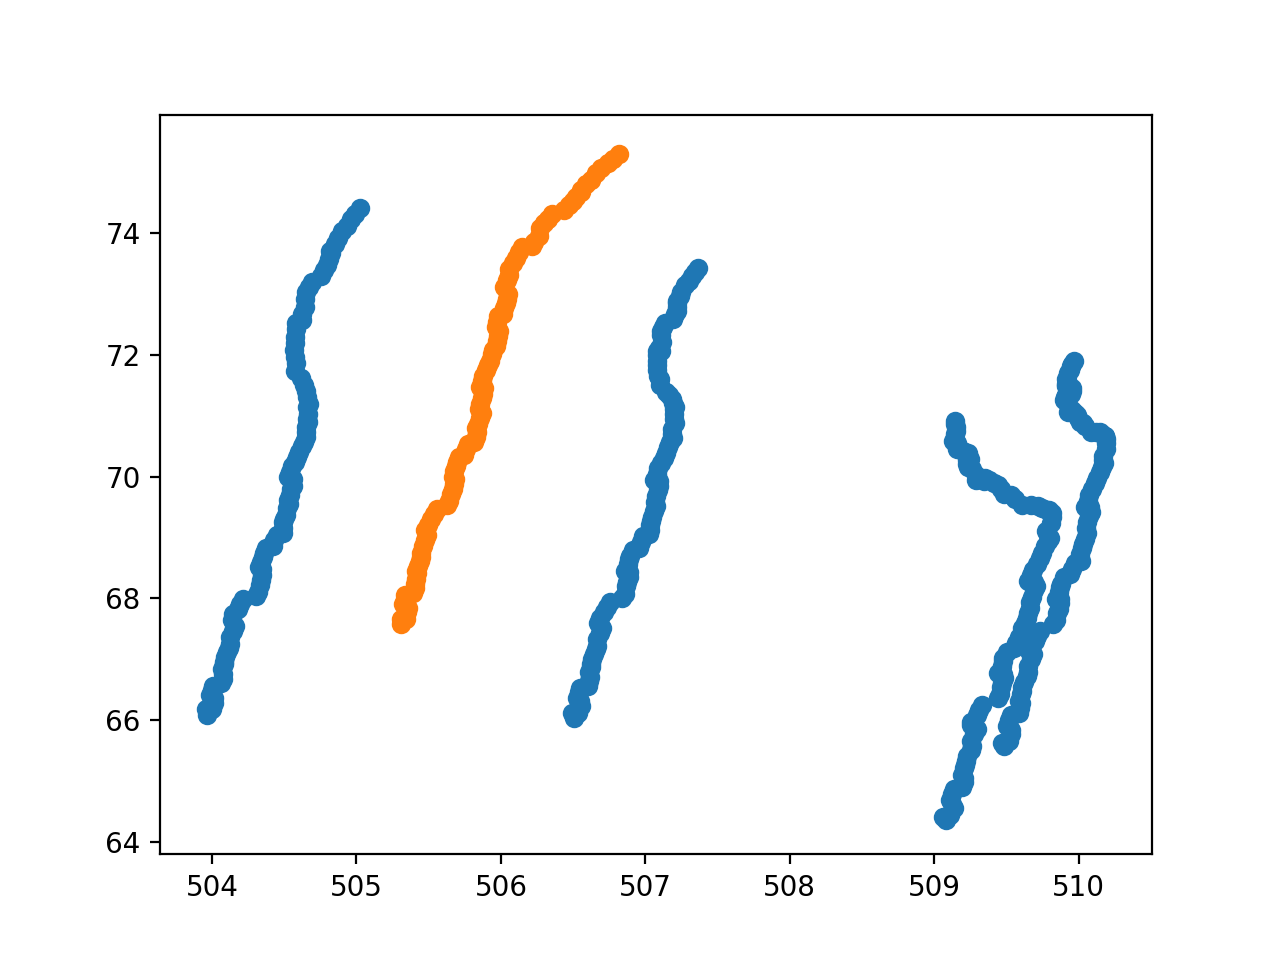

In [154]:
glx, gly, robx, roby = get_traj(bag1, 230, 100)
plt.figure(6)
plt.scatter(glx, gly)
plt.scatter(robx, roby)